In [3]:
pip install gym==0.10

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\dcnlab\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 0.19181661307811737 0
20 0.09651574492454529 5
40 0.05588400363922119 15
60 0.073745496571064 34
80 0.0362287200987339 53
100 0.050849054008722305 73
120 0.06220479682087898 93
140 0.020527590066194534 113
160 0.03891947120428085 133
180 0.055885206907987595 153
200 0.04712040722370148 173
220 0.03638633340597153 193
240 0.024265557527542114 213
260 0.013817578554153442 233
280 0.011305389925837517 253
300 0.03771745041012764 273
320 0.022935567423701286 293
340 0.02785838022828102 313
360 0.016402915120124817 333
380 0.010910830460488796 353
400 0.008007250726222992 373
420 0.009609770961105824 393
440 0.00775505555793643 413
460 0.0019206703873351216 433
480 0.0029069227166473866 453
500 0.001690368982963264 473
520 0.0021419860422611237 493
540 0.004788275808095932 513
560 0.0026911741588264704 533
580 0.001373501610942185 553
600 0.002247854368761182 573
620 0.0036569011863321066 59

Text(0, 0.5, 'qval')

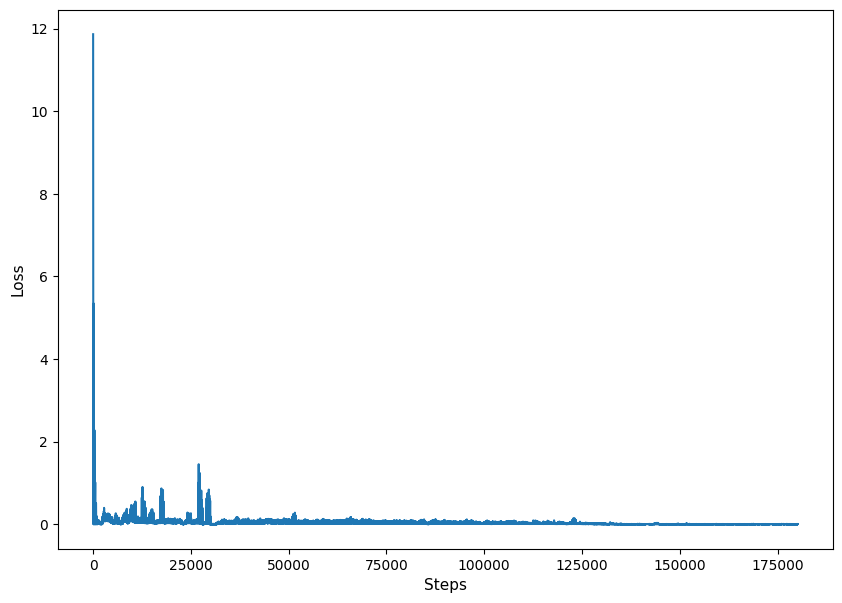

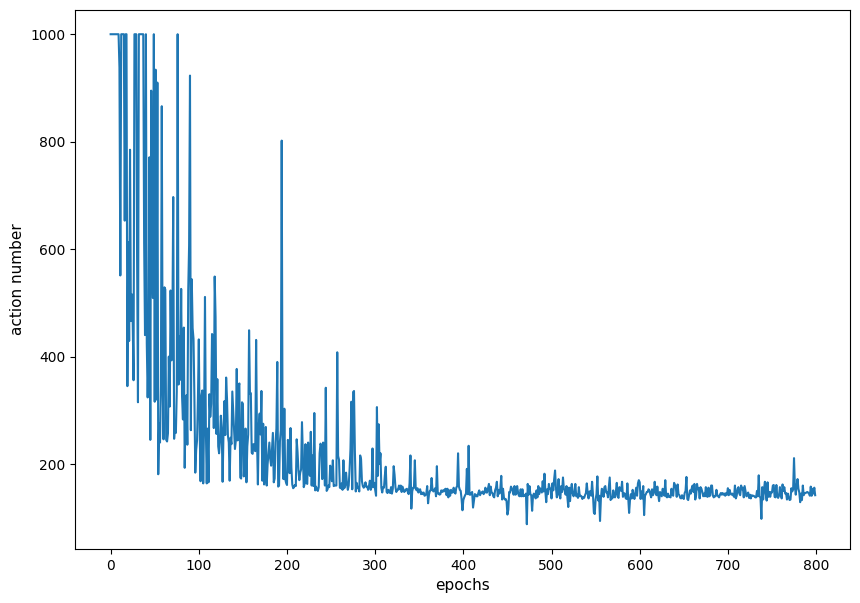

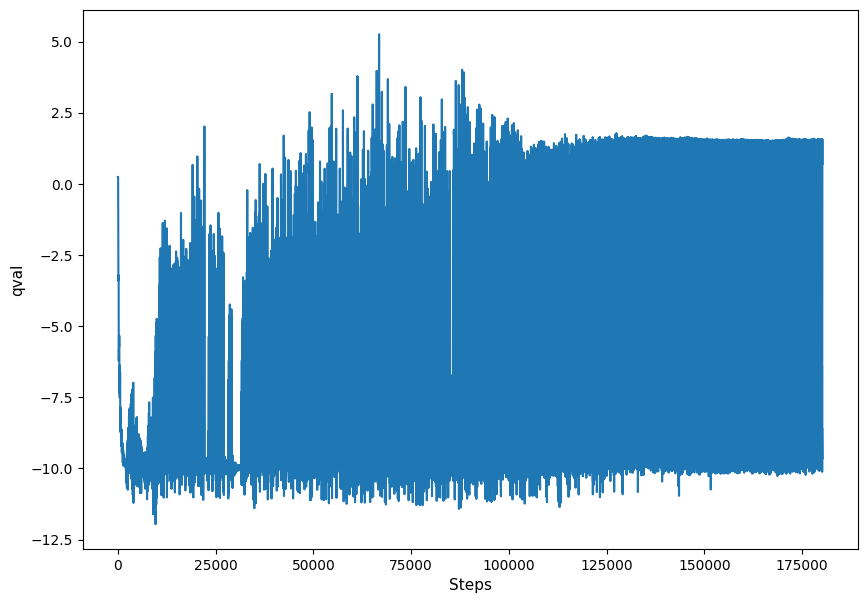

In [4]:
import copy
from sre_constants import SUCCESS
import numpy as np
import torch
import random
from matplotlib import pylab as plt
import gym
import itertools
#from gym import wrappers 
from IPython.display import clear_output

L1 = 2
L2 = 150
L3 = 100
L4 = 3
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #target network
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.6

env = gym.envs.make('MountainCar-v0')
env = env.unwrapped
#env = wrappers.Monitor(env,"C:\testml\video",video_callable=lambda count:count%10==0)
#env.Monitor.start('C:\testml\video',video_callable=lambda count: count % 10 == 0)

from collections import deque
epochs = 800 #訓練次數
losses = []
step_num = []
qval_record=[]
mem_size = 1000 
batch_size = 64 #batch_size
replay = deque(maxlen=mem_size) #replay buffer
max_moves = 1000 #每場遊戲最多可以走幾步
sync_freq = 200
success_flag=0
success_num=0
j=0
multi_step=4
state1_batch = torch.tensor([])
action_batch = torch.tensor([])
reward_batch = torch.tensor([])
state2_batch = torch.tensor([])
done_batch = torch.tensor([])
for i in range(epochs):
    state1_ = env.reset()
    state1 = torch.from_numpy(state1_).float()
    status = 1
    success_flag=0
    mov = 0     #記錄移動的步數
    while(status == 1): 
        j += 1
        mov += 1
        qval = model(state1) #輸出各動作的Q值
        #print(qval,i)
        qval_ = qval.data.numpy()
        qval_record.append(np.max(qval_))
        if (random.random() < epsilon):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)
        state2_, reward , done , info= env.step(action_)
        #env.render() 
        #print(state2_)
        """
        if reward != -1:
            #step_num.append(mov)
            success_flag=1
            success_num+=1
            reward=200
        """

        if mov == 700 :
            reward = reward -  0.5
        if state2_[0] >= -0.4 :
            reward +=  0.2 + state2_[0]
        if state2_[1] >= 0.02 :
            reward +=   0.2 + state2_[1]*10

        if state2_[0] > 0.5 and success_flag == 0:
            status = 0
            #reward += 20
            success_num+=1
            step_num.append(mov)
            success_flag=1
        
        #if state2_[0] > 0.5:
                #reward = 5
        #elif state2_[0] <= -0.6:
            #reward = -1 + state2_[0]
        state2 = torch.from_numpy(state2_).float()
        #print(i)
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2 
        #print(state1)
        #print(len(replay),batch_size)     

        if len(replay) > batch_size:
            """minibatch = random.sample(replay, batch_size)
            state1_batch_ = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch_ = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            state1_batch = torch.reshape(state1_batch_, (64, 2))
            state2_batch = torch.reshape(state2_batch_, (64, 2))"""
            action_sample, reward_sample, done_sample = [], [], []
            state1_batch = torch.tensor([])
            state2_batch = torch.tensor([])
            for k in range(batch_size):
                finish = random.randint(multi_step, len(replay) - 1)
                begin = finish-multi_step
                sum_reward = 0      #n_step rewards
                data = deque(itertools.islice(replay,begin,finish))
                #print(data)
                state_sample = data[0][0]
                action_sample.append(data[0][1])
                for m in range(multi_step):
                #compute the n-th reward
                    sum_reward += (gamma**m) * data[m][2]
                    if data[m][4]:
                        # manage end of episode
                        state_look_ahead = data[m][3]
                        done_look_ahead = True
                        break
                    else:
                        state_look_ahead = data[m][3]
                        done_look_ahead = False
                #print(state1_batch,state_sample)
                #tuple = (state1_batch, state_sample)
                state1_batch=torch.cat((state1_batch, state_sample))
                reward_sample.append(sum_reward)
                #tuple = (state2_batch, state_look_ahead)
                state2_batch=torch.cat((state2_batch, state_look_ahead))
                done_sample.append(done_look_ahead)
            state1_batch = torch.reshape(state1_batch, (64, 2))
            state2_batch = torch.reshape(state2_batch, (64, 2))
            reward_batch=torch.Tensor(reward_sample)
            action_batch=torch.Tensor(action_sample)
            done_batch=torch.Tensor(done_sample)
            Q1 = model(state1_batch) 
            with torch.no_grad():     
                Q2 = model2(state2_batch) 
            Y = reward_batch + (gamma **multi_step)*(1-done_batch)*torch.max(Q2,dim=1)[0]
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            losses.append(loss.item())    

            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
            
        if reward == 200 or mov > max_moves:
            status = 0 
            mov = 0
        #losses.append(loss.item())  
    if epsilon > 0.001: 
        epsilon -= (1/epochs) 
    """if i % 100 == 0:
        if i!=0 and i%1000 == 0 :
            print(i,loss)
        else:
            print(i)"""
    if success_flag == 0:
        step_num.append(1000)
    if i%20 == 0:
      print(i, loss.item(),success_num)
    #print('\r')
    #print(i, loss.item(),success_num)
    #print('\r\b')
#env.close()
#test_model(model)
print(i, loss.item(),success_num)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

plt.figure(figsize=(10,7))
plt.plot(step_num)
plt.xlabel("epochs",fontsize=11)
plt.ylabel("action number",fontsize=11)

plt.figure(figsize=(10,7))
plt.plot(qval_record)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("qval",fontsize=11)




In [ ]:
"""def test_model(model):
  i = 0
  env = gym.envs.make('MountainCar-v0')
  env = env.unwrapped
  for i in range(10):
    state3_ = env.reset()  
    env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0
    while(status == 1):    
      mov += 1
      qval = model(state3)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      print(action_)
      observation, reward, done, info = env.step(action_)
      state3=torch.from_numpy(observation).float()
      #print(action_,reward,done)
      #print(observation)
      env.render()
      if mov >= 1000:
        status=0
      #time.sleep(0.02)
      #env.render()    
    print(i)
  env.close()"""

In [6]:

#env = gym.envs.make('MountainCar-v0')
#env = env.unwrapped
test_s=0
for i in range(1000):
    state3_ = env.reset()  
    #env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0 
    while(status == 1):    
        mov += 1
        qval = model(state3)
        qval_ = qval.data.numpy()
        """if (random.random() < 0.1):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)"""
        action_ = np.argmax(qval_)
        #state2_, reward , done , info= env.step(action_)
        #action_ = np.argmax(qval_) 
        #print(action_)
        observation, reward, done, info = env.step(action_)
        if done == True:
            print("true",i)
        state3=torch.from_numpy(observation).float()
        #print(action_,reward,done)
        #print(observation)
        #env.render()
        if observation[0] > 0.5 :
            status = 0
            test_s += 1
        if mov >= 1000:
            status=0
        
        #env.render()    
    #print(i)
print(test_s)
#env.close()

true 0
true 1
true 2
true 3
true 4
true 5
true 6
true 7
true 8
true 9
true 10
true 11
true 12
true 13
true 14
true 15
true 16
true 17
true 18
true 19
true 20
true 21
true 22
true 23
true 24
true 25
true 26
true 27
true 28
true 29
true 30
true 31
true 32
true 33
true 34
true 35
true 36
true 37
true 38
true 39
true 40
true 41
true 42
true 43
true 44
true 45
true 46
true 47
true 48
true 49
true 50
true 51
true 52
true 53
true 54
true 55
true 56
true 57
true 58
true 59
true 60
true 61
true 62
true 63
true 64
true 65
true 66
true 67
true 68
true 69
true 70
true 71
true 72
true 73
true 74
true 75
true 76
true 77
true 78
true 79
true 80
true 81
true 82
true 83
true 84
true 85
true 86
true 87
true 88
true 89
true 90
true 91
true 92
true 93
true 94
true 95
true 96
true 97
true 98
true 99
true 100
true 101
true 102
true 103
true 104
true 105
true 106
true 107
true 108
true 109
true 110
true 111
true 112
true 113
true 114
true 115
true 116
true 117
true 118
true 119
true 120
true 121
true 122
tru

KeyboardInterrupt: 

In [ ]:
#test_model(model)
torch.max(Q2,dim=1)

In [ ]:
Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()